In [1]:
import pandas as pd
import numpy as np
import json
import hashlib
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, classification_report, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from IPython.display import HTML
style = "<style>svg{width: 70% !important; height: 80% !important;} </style>"
HTML(style)

### Обезличивание и загрузка данных

In [2]:
# Define a custom date parsing function
def parse_datetime(date_string):
    return pd.to_datetime(date_string, format='%d.%m.%Y %H:%M:%S')

In [3]:
# df = pd.read_excel('ИсходныеДанные.xlsx')
# df.to_csv('ИсходныеДанные.csv', index = None, header=True)

In [4]:
%%time
df = pd.read_csv('ИсходныеДанные.csv', parse_dates=['ДатаЗаказа', 'ДатаПоследнегоСтатуса'], date_parser=parse_datetime)

# delete na rows
df = df.dropna()

# unfacing mobile phones
# df['user_code'] = df['Телефон'].apply(lambda x: hashlib.md5(str(x).encode()).hexdigest())
# df = df.drop(columns=['Телефон'])

# add delivery days
df['DaysDelivery'] = (df['ДатаПоследнегоСтатуса'] - df['ДатаЗаказа']).dt.days

# cut 15 days from data
df = df[df['ДатаЗаказа'] < (df.ДатаЗаказа.max() - pd.DateOffset(days=15))]

# leave only delivered less than 60 days and less 7 trying
df = df[(df['DaysDelivery'] <= 60) & (df['ПопыткиДоставки'] <= 7)]

# Covert departments to codes
df['Department'] = df['Подразделение'].astype('category').cat.codes
department_codes = dict(zip(df['Подразделение'], df['Department']))
# df['Department'] = LabelEncoder().fit_transform(df['Подразделение'])

# add redeemed
df['Redeemed'] = df['Статус'].apply(lambda x: 1 if x == 'Выкуплен' else 0)

# del document number
# df = df.drop(columns=['Номер'])

df['Weekday'] = df['ДатаПоследнегоСтатуса'].dt.weekday

CPU times: total: 3.05 s
Wall time: 4.07 s


In [5]:
df

,Номер,ДатаЗаказа,Статус,ПопыткиДоставки,ДатаПоследнегоСтатуса,СуммаДокумента,Подразделение,DaysDelivery,Department,Redeemed,Weekday
0,DL00-037866,2022-01-03 18:21:58,Выкуплен,1.0,2022-01-06 19:31:42,8524.0,Владикавказ,3,7,1,3
1,DL00-037878,2022-01-03 18:37:55,Выкуплен,1.0,2022-01-06 10:33:27,6734.0,Казань,2,14,1,3
2,DL00-037885,2022-01-03 19:16:34,Выкуплен,1.0,2022-01-06 10:33:28,8524.0,Казань,2,14,1,3
3,DL00-037886,2022-01-03 19:16:36,Выкуплен,1.0,2022-01-06 10:33:27,2800.0,Казань,2,14,1,3
4,DL00-037942,2022-01-04 12:24:35,Не выкуплен,1.0,2022-01-14 13:13:02,3700.0,Иркутск,10,13,0,4
...,...,...,...,...,...,...,...,...,...,...,...
332361,DL00-335985,2023-06-11 15:11:56,Не выкуплен,1.0,2023-06-30 13:39:24,5034.0,Краснодар,18,18,0,4
332362,DL00-336003,2023-06-11 15:14:05,Выкуплен,1.0,2023-06-12 19:54:37,7300.0,Крым,1,20,1,0
332363,DL00-336042,2023-06-11 15:22:49,Выкуплен,1.0,2023-06-12 19:57:48,5500.0,Махачкала,1,24,1,0
332364,DL00-336056,2023-06-11 15:23:49,Выкуплен,1.0,2023-06-12 22:52:05,7838.0,Пятигорск,1,37,1,0


In [6]:
df = df.rename(columns={"ПопыткиДоставки": "DeliveryAttempt", "СуммаДокумента": "OrderAmount"})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311873 entries, 0 to 332365
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Номер                  311873 non-null  object        
 1   ДатаЗаказа             311873 non-null  datetime64[ns]
 2   Статус                 311873 non-null  object        
 3   DeliveryAttempt        311873 non-null  float64       
 4   ДатаПоследнегоСтатуса  311873 non-null  datetime64[ns]
 5   OrderAmount            311873 non-null  float64       
 6   Подразделение          311873 non-null  object        
 7   DaysDelivery           311873 non-null  int64         
 8   Department             311873 non-null  int8          
 9   Redeemed               311873 non-null  int64         
 10  Weekday                311873 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(3), int8(1), object(3)
memory usage: 26.5+ MB


### Процент успешных доставок по количеству попыток доставки

In [9]:
success_percentage = df.groupby('DeliveryAttempt')['Redeemed'].mean()*100
success_percentage

DeliveryAttempt
1.0    64.996308
2.0    66.171740
3.0    56.061115
4.0    48.258706
5.0    43.353474
6.0    38.436482
7.0    34.959350
Name: Redeemed, dtype: float64

<AxesSubplot: xlabel='DeliveryAttempt'>

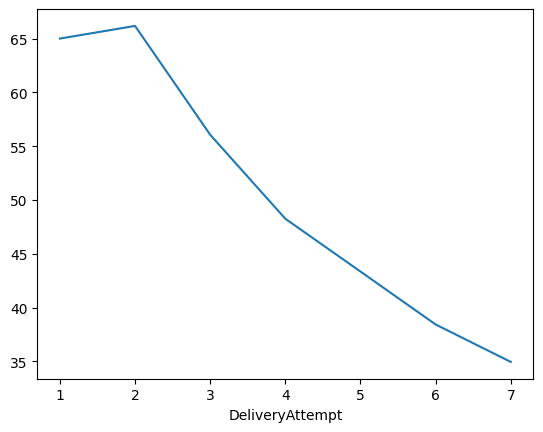

In [10]:
success_percentage.plot()

### Процент успешных доставок по количеству дней доставки

In [11]:
success_percentage = df.groupby('DaysDelivery')['Redeemed'].mean()*100
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(success_percentage)

DaysDelivery
0     80.381091
1     82.451543
2     68.331816
3     62.286585
4     40.460310
5     32.114768
6     27.180952
7     18.614884
8     34.853831
9     13.087745
10    11.969904
11     7.825831
12    10.080183
13     8.923997
14     7.928731
15    21.731959
16    11.235955
17     8.557951
18     9.187859
19     9.335900
20     9.538462
21     7.494407
22    20.021645
23     8.708709
24     9.333333
25    10.371820
26     6.172840
27     5.854801
28     8.292683
29    24.349882
30     9.705882
31    10.032362
32     8.487085
33     7.037037
34     6.976744
35     5.339806
36    18.750000
37     6.081081
38    10.303030
39     0.847458
40     5.833333
41     5.511811
42     9.166667
43    13.223140
44     5.617978
45    10.769231
46    10.389610
47     3.030303
48    19.444444
49     3.703704
50    16.176471
51     4.761905
52    18.367347
53    13.636364
54    11.428571
55     4.347826
56    17.500000
57    22.500000
58     6.060606
59     9.677419
60    11.111111
Name: Redee

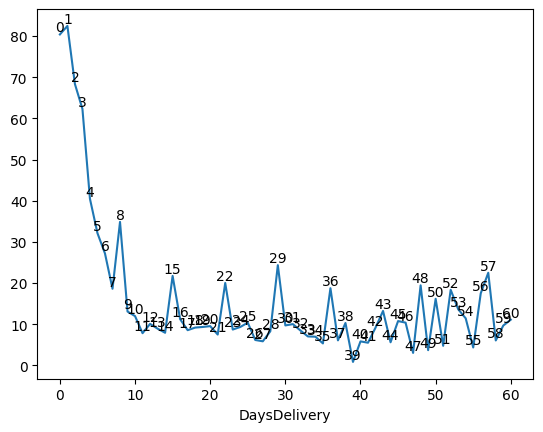

In [12]:
ax = success_percentage.plot()
# Add text annotations for each value
for i, value in enumerate(success_percentage):
    ax.text(i, value, f'{i}', ha='center', va='bottom')

### Дерево решений

In [13]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=13)
clf

DecisionTreeClassifier(criterion='entropy', max_depth=13)

In [14]:
X = df[['DeliveryAttempt', 'DaysDelivery', 'Department', 'OrderAmount', 'Weekday']]
y = df.Redeemed

In [15]:
# X = pd.get_dummies(X)
X

,DeliveryAttempt,DaysDelivery,Department,OrderAmount,Weekday
0,1.0,3,7,8524.0,3
1,1.0,2,14,6734.0,3
2,1.0,2,14,8524.0,3
3,1.0,2,14,2800.0,3
4,1.0,10,13,3700.0,4
...,...,...,...,...,...
332361,1.0,18,18,5034.0,4
332362,1.0,1,20,7300.0,0
332363,1.0,1,24,5500.0,0
332364,1.0,1,37,7838.0,0


In [16]:
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=13)

In [17]:
# %%time
# plt.figure(figsize=(80, 40),dpi=80)
# p = tree.plot_tree(clf, fontsize=30,filled=True,feature_names=list(X))

In [18]:
clf.score(X, y)

0.8342626646102741

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

In [20]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=13)

In [21]:
clf.score(X_test, y_test)

0.8228121143812124

### Try getting as better values as possible

In [22]:
scores_data = pd.DataFrame()
for max_depth in range(1, 20):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    temp_scores_data = pd.DataFrame({'max_depth': [max_depth], 
                                     'score_train': [score_train], 
                                     'score_test': [score_test],
                                     'cross_val_score': [mean_cross_val_score]
                                    })
    scores_data = pd.concat([scores_data, temp_scores_data], ignore_index=True)

In [23]:
scores_data

,max_depth,score_train,score_test,cross_val_score
0,1,0.783010,0.784316,0.783010
1,2,0.785029,0.786113,0.785029
2,3,0.802827,0.804642,0.802727
3,4,0.802827,0.804642,0.802727
4,5,0.809681,0.808548,0.809504
5,6,0.814002,0.814922,0.813691
6,7,0.817874,0.816487,0.816668
7,8,0.824186,0.822045,0.822588
8,9,0.826483,0.823745,0.823454
9,10,0.828541,0.823463,0.823799


In [24]:
scores_data_long = pd.melt(scores_data, 
                           id_vars = ['max_depth'], 
                           value_vars = ['score_train','score_test', 'cross_val_score'], 
                           var_name = 'set_type', 
                           value_name = 'score')

In [25]:
scores_data_long[scores_data_long.set_type=='cross_val_score'].sort_values(by='score', ascending=False)

,max_depth,set_type,score
47,10,cross_val_score,0.823799
48,11,cross_val_score,0.823732
46,9,cross_val_score,0.823454
45,8,cross_val_score,0.822588
49,12,cross_val_score,0.822420
50,13,cross_val_score,0.821047
51,14,cross_val_score,0.820190
52,15,cross_val_score,0.818429
44,7,cross_val_score,0.816668
53,16,cross_val_score,0.815462


<AxesSubplot: xlabel='max_depth', ylabel='score'>

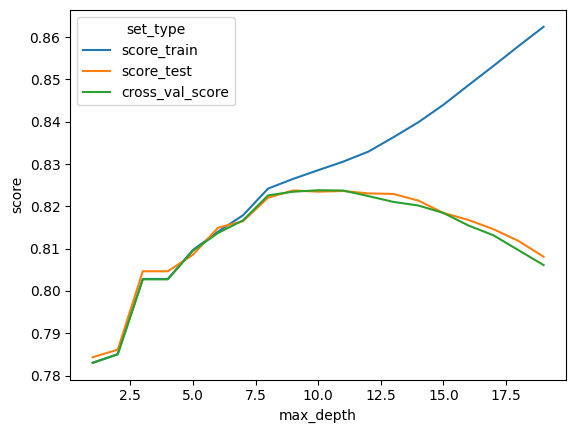

In [26]:
sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)

# GridSearchCV

In [27]:
clf = tree.DecisionTreeClassifier()
clf

DecisionTreeClassifier()

In [28]:
parameters = {'criterion':['gini', 'entropy'], 'max_depth': range(1,20)}

In [29]:
grid_search_cv_slf = GridSearchCV(clf, parameters, cv=5)

In [30]:
grid_search_cv_slf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20)})

In [31]:
grid_search_cv_slf.best_params_

{'criterion': 'entropy', 'max_depth': 10}

In [32]:
best_clf = grid_search_cv_slf.best_estimator_

In [33]:
best_clf.score(X_test, y_test)

0.8234436790097066

In [34]:
report = classification_report(y_test, best_clf.predict(X_test), target_names=['Non-redeemed', 'redeemed'])
print(report)

              precision    recall  f1-score   support

Non-redeemed       0.87      0.58      0.70     36268
    redeemed       0.81      0.95      0.87     66651

    accuracy                           0.82    102919
   macro avg       0.84      0.77      0.79    102919
weighted avg       0.83      0.82      0.81    102919



In [35]:
y_pred = best_clf.predict(X_test)
y_pred

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [36]:
y_pred_prob = best_clf.predict_proba(X_test)
y_pred_prob

array([[0.17838176, 0.82161824],
       [0.14324961, 0.85675039],
       [0.13306829, 0.86693171],
       ...,
       [0.8057554 , 0.1942446 ],
       [0.28      , 0.72      ],
       [0.20885358, 0.79114642]])

<AxesSubplot: >

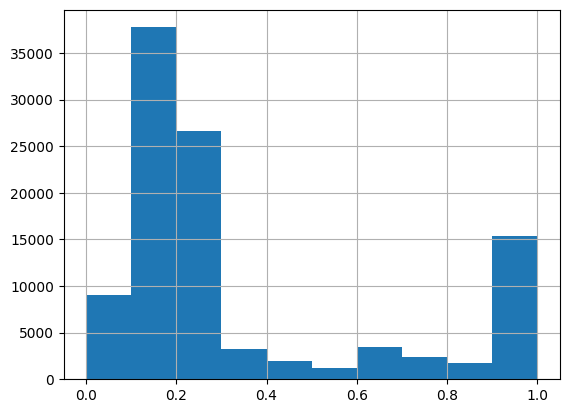

In [37]:
# Гистрограмма что не будут доставлены
pd.Series(y_pred_prob[:, 0]).hist()

<AxesSubplot: >

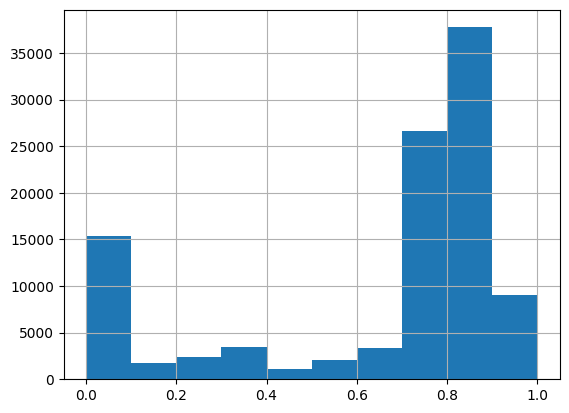

In [38]:
# Гистрограмма что будут доставлены
pd.Series(y_pred_prob[:, 1]).hist()

In [39]:
y_pred = np.where(y_pred_prob[:, 1]>0.8, 1, 0)
print('precision_score=' + str(precision_score(y_test, y_pred)))
print('recall_score=' + str(recall_score(y_test, y_pred)))

precision_score=0.8510770151294983
recall_score=0.597545423174446


### ROC кривая

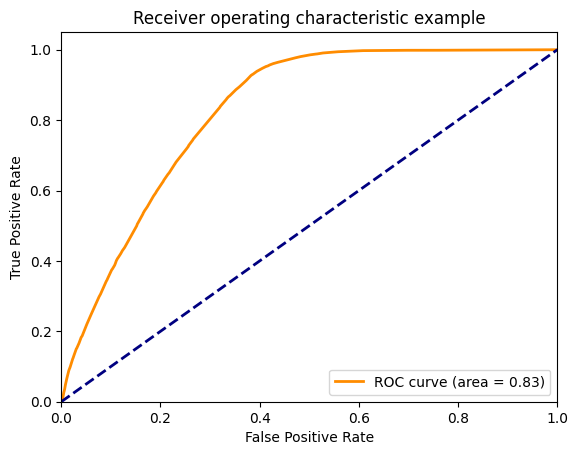

In [40]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
lw = 2
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Save model and departments

In [41]:
# import pickle
# pickle.dump(best_clf, open('clf_model.sav', 'wb'))
# with open('department_codes.json', 'w') as f:
#     json.dump(department_codes, f)

### Random forest

In [42]:
clf_rf = RandomForestClassifier(random_state=42)

In [43]:
# parameters = {'n_estimators': [100, 150, 200], 'max_depth': [11, 12, 13, 14]}
param_grid = { 
    'n_estimators': [200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5, 10, 15],
    'criterion' :['gini', 'entropy']
}

In [44]:
grid_search_cv_clf = GridSearchCV(clf_rf, param_grid, cv=5, n_jobs=-1)

In [45]:
%%time
grid_search_cv_clf.fit(X_train, y_train)

C:\Users\NovPa\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\NovPa\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\NovPa\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\NovPa\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 637, in _validate_params
    valida

CPU times: total: 34.8 s
Wall time: 22min 13s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 300]})

In [46]:
grid_search_cv_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [47]:
clf_rf_best = grid_search_cv_clf.best_estimator_
clf_rf_best

RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=200,
                       random_state=42)

In [48]:
clf_rf_best.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=200,
                       random_state=42)

In [49]:
clf_rf_best.score(X_test, y_test)

0.8274954090109697

In [50]:
feature_importance = clf_rf_best.feature_importances_

In [51]:
imp = pd.DataFrame(feature_importance, index=X_train.columns, columns=['importance'])
imp.sort_values('importance', ascending=False)

,importance
DaysDelivery,0.549937
DeliveryAttempt,0.147935
OrderAmount,0.125566
Department,0.104104
Weekday,0.072458


<AxesSubplot: >

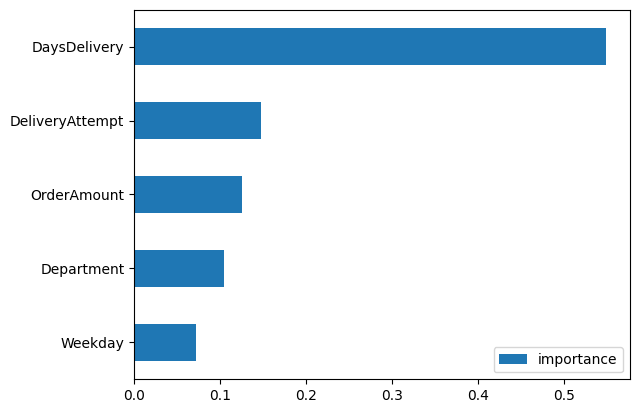

In [52]:
imp.sort_values('importance').plot(kind='barh', )